In [1]:
import numpy as np
from loader.Toy_dataset import Toy, toy_visualizer, pallete

import matplotlib.pyplot as plt
from models import load_pretrained

device = 'cuda:0' # 'cpu' or 'cuda:0'

## Datasets

Toy split training | torch.Size([10, 201, 2])
Toy split training | torch.Size([15, 201, 2])
Toy split training | torch.Size([20, 201, 2])


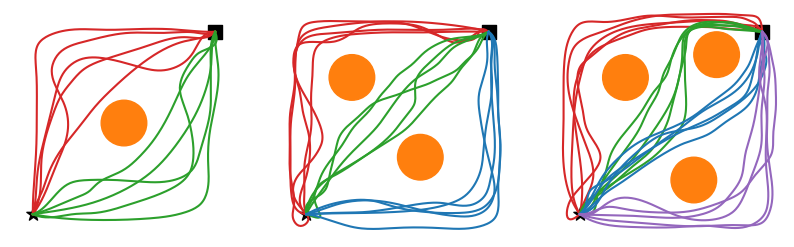

In [2]:
ds1 = Toy('datasets/EXP1/')
ds2 = Toy('datasets/EXP2/')
ds3 = Toy('datasets/EXP3/')

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
toy_visualizer(ds1.env, axs[0], traj=ds1.data, label=ds1.targets)
toy_visualizer(ds2.env, axs[1], traj=ds2.data, label=ds2.targets)
toy_visualizer(ds3.env, axs[2], traj=ds3.data, label=ds3.targets)

## Visualize Results

In [3]:
exp_num = 2 # choose among 1, 2, 3
if exp_num == 1:
    ds = ds1
    n_components = 2
elif exp_num == 2:
    ds = ds2
    n_components = 3
elif exp_num == 3:
    ds = ds3
    n_components = 4
    
n_samples = 300
alpha1 = 0.5
alpha2 = 0.3

mmppp_zdim = 2
immppp_zdim = 2
immppp_iso_reg = 1000 # choose iso reg among the list of regs you used in training IMMP++

root = f'results/toy/exp{exp_num}/'
mmppp_best_identifier = f'mmppp_zdim{mmppp_zdim}'
immppp_best_identifier = f'immppp_zdim{immppp_zdim}_reg{immppp_iso_reg}'

model_selection_criteria = 'recon' # choose among 'mmd', 'recon'
if model_selection_criteria == 'mmd':
    ckpt_file = 'model_besteval.pkl'
elif model_selection_criteria == 'recon':
    ckpt_file = 'model_best.pkl'

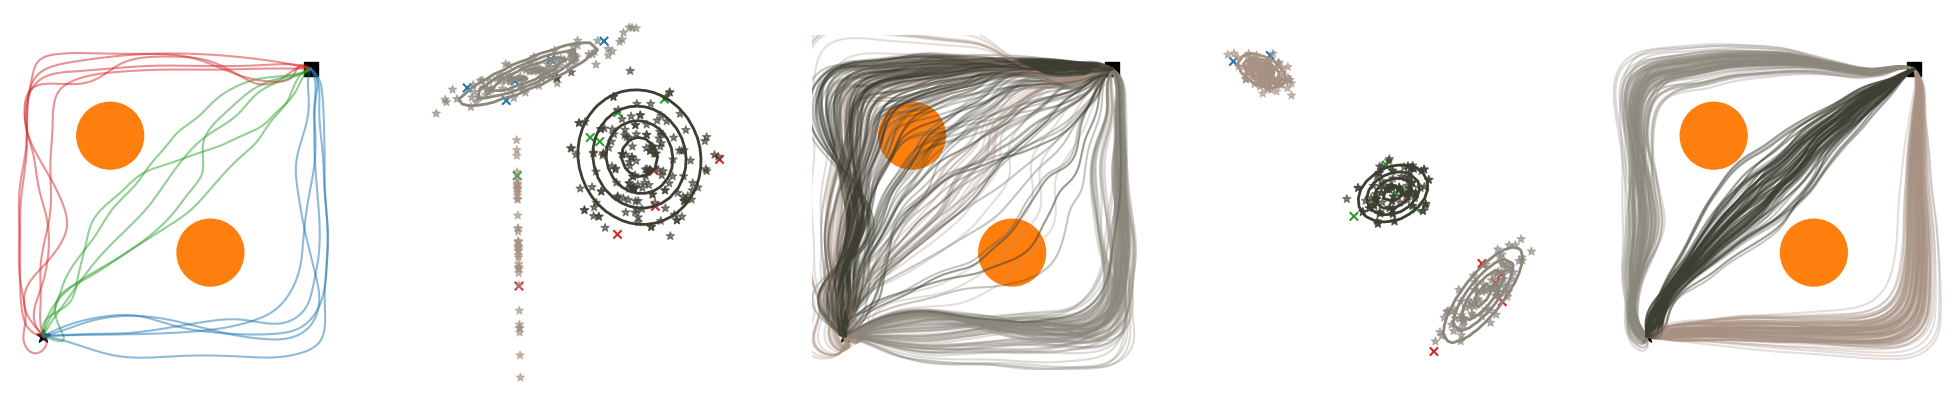

In [4]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

toy_visualizer(
    ds.env, 
    axs[0], 
    traj=ds.data, 
    label=ds.targets, 
    alpha=alpha1)

#########
# MMPpp #
#########
mmppp, _ = load_pretrained(
    root=root,
    identifier=mmppp_best_identifier,
    config_file='mmppp.yml',
    ckpt_file=ckpt_file
)
mmppp.to(device);

w = mmppp.get_w_from_traj(ds.data.to(device))
latent_values = mmppp.encode(w).detach().cpu()
axs[1].scatter(
    latent_values[:,0], 
    latent_values[:,1],
    c=[pallete[i] for i in ds.targets],
    marker='x',
    )
axs[1].axis('equal')
axs[1].axis('off')

mmppp.fit_GMM(ds.data.to(device), n_components=n_components)

dict_samples = mmppp.sample(n_samples, device=device, traj_len=201)
q_traj = dict_samples['q_traj_samples'].detach().cpu()
z_samples = dict_samples['z_samples'].detach().cpu()

axs[1].scatter(
    z_samples[:,0], 
    z_samples[:,1],
    c=[pallete[i] for i in 10-dict_samples['cluster_samples']],
    alpha=0.6,
    marker='*',
    )

sample_y = dict_samples['cluster_samples'].numpy()

xmin, xmax = axs[1].get_xbound()
ymin, ymax = axs[1].get_ybound()
for i, (mu, cov) in enumerate(zip(mmppp.gmm.means_, mmppp.gmm.covariances_)):
    tempZ = z_samples[sample_y == i]
    x = np.linspace(xmin, xmax, 40)
    y = np.linspace(ymin, ymax, 40)
    xx, yy = np.meshgrid(x, y) 
    delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

    zz = np.exp(np.diagonal(
        -(delta@np.linalg.inv(cov)@delta.transpose())
    )/2)
    
    c = sample_y[sample_y == i].reshape(-1,1)
    contour = axs[1].contour(
        xx.reshape(40, 40), 
        yy.reshape(40, 40), 
        zz.reshape(40, 40),
        levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
        colors=pallete[10-i],
        linewidths=2,
        )
    
toy_visualizer(
    ds.env, 
    axs[2], 
    traj=q_traj, 
    label=10-dict_samples['cluster_samples'], 
    alpha=alpha2)

##################
##### IMMPpp #####
##################
mmppp, _ = load_pretrained(
    root=root,
    identifier=immppp_best_identifier,
    config_file='immppp.yml',
    ckpt_file=ckpt_file
)
mmppp.to(device);

w = mmppp.get_w_from_traj(ds.data.to(device))
latent_values = mmppp.encode(w).detach().cpu()
axs[3].scatter(
    latent_values[:,0], 
    latent_values[:,1],
    c=[pallete[i] for i in ds.targets],
    marker='x',
    )
axs[3].axis('equal')
axs[3].axis('off')

mmppp.fit_GMM(ds.data.to(device), n_components=n_components)

dict_samples = mmppp.sample(n_samples, device=device, traj_len=201)
q_traj = dict_samples['q_traj_samples'].detach().cpu()
z_samples = dict_samples['z_samples'].detach().cpu()

axs[3].scatter(
    z_samples[:,0], 
    z_samples[:,1],
    c=[pallete[i] for i in 10-dict_samples['cluster_samples']],
    alpha=0.6,
    marker='*',
    )

sample_y = dict_samples['cluster_samples'].numpy()

xmin, xmax = axs[3].get_xbound()
ymin, ymax = axs[3].get_ybound()
for i, (mu, cov) in enumerate(zip(mmppp.gmm.means_, mmppp.gmm.covariances_)):
    tempZ = z_samples[sample_y == i]
    x = np.linspace(xmin, xmax, 40)
    y = np.linspace(ymin, ymax, 40)
    xx, yy = np.meshgrid(x, y) 
    delta = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1) - mu.reshape(1, -1)

    zz = np.exp(np.diagonal(
        -(delta@np.linalg.inv(cov)@delta.transpose())
    )/2)
    
    c = sample_y[sample_y == i].reshape(-1,1)
    contour = axs[3].contour(
        xx.reshape(40, 40), 
        yy.reshape(40, 40), 
        zz.reshape(40, 40),
        levels=[0.3, 0.5, 0.7, 0.9, 0.9999], 
        colors=pallete[10-i],
        linewidths=2,
        )
    
toy_visualizer(
    ds.env, 
    axs[4], 
    traj=q_traj, 
    label=10-dict_samples['cluster_samples'], 
    alpha=alpha2)